In [2]:
import bench_lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bench_plot_lib as plot_lib

import importlib
importlib.reload(bench_lib)
importlib.reload(plot_lib)

GiB = 2**30

SYS_NAME = "cache_ext"
FIGURES_DIR = "figures/"
iops_select_fn = lambda r: r["jobs"][0]["read"]["iops"]
leveldb_throughput_avg_select_fn = lambda r: r["throughput_avg"]
leveldb_latency_p99_select_fn = lambda r: r["latency_p99"] / 10**3
leveldb_read_latency_p99_select_fn = lambda r: r["read_latency_p99"] / 10**3

def filter_cgroup_results(results, cgroup_name):
    return [r for r in results if r.config["cgroup_name"] == cgroup_name]

def filter_cache_ext_results(results):
    return filter_cgroup_results(results, bench_lib.DEFAULT_CACHE_EXT_CGROUP)

## Filesearch Benchmark

In [13]:
baseline_filesearch_results = bench_lib.parse_results_file("baseline_filesearch_results.json", bench_lib.BenchResults)
cache_ext_filesearch_results = bench_lib.parse_results_file("filesearch_results.json", bench_lib.BenchResults)
cache_ext_filesearch_results = filter_cache_ext_results(cache_ext_filesearch_results)
filesearch_results = baseline_filesearch_results + cache_ext_filesearch_results

config_matches = [{"name": "filesearch_benchmark"}]
config_matches = bench_lib.add_config_option("cgroup_size", [1* GiB], config_matches)
config_matches = bench_lib.add_config_option("cgroup_name", [bench_lib.DEFAULT_BASELINE_CGROUP, bench_lib.DEFAULT_CACHE_EXT_CGROUP], config_matches)

runtime_select_fn = lambda r: r["runtime_sec"]

plot_lib.bench_plot_groupped_results(
    config_matches,
    filesearch_results,
    y_label="Runtime (s)",
    show_measurements=False,
    colors=["salmon", "limegreen"],
    bench_types=["filesearch"],
    result_select_fn=runtime_select_fn,
    bench_type_to_group={"filesearch": "File Search"},
    filename=FIGURES_DIR + "filesearch_results.pdf"
    )

{'name': 'filesearch_benchmark', 'cgroup_size': 1073741824, 'cgroup_name': 'baseline_test', 'benchmark': 'filesearch'}
[45.02097177505493]
{'name': 'filesearch_benchmark', 'cgroup_size': 1073741824, 'cgroup_name': 'cache_ext_test', 'benchmark': 'filesearch'}
[24.680588006973267]
[[45.02097177505493], [24.680588006973267]]
['Baseline', 'cache_ext']
[-0.5  0.5]
[-0.5]
[0.5]


<Figure size 432x288 with 0 Axes>

## Generic Policies

In [18]:
# YCSB results

baseline_ycsb_results = bench_lib.parse_results_file("baseline_lfu_ycsb_results.json", bench_lib.BenchResults)
cache_ext_filesearch_results = bench_lib.parse_results_file("lfu_ycsb_results.json", bench_lib.BenchResults)
cache_ext_filesearch_results = filter_cache_ext_results(cache_ext_filesearch_results)
ycsb_results = baseline_ycsb_results + cache_ext_filesearch_results

config_matches = [
    {
        "name": "leveldb_benchmark",
        "iteration": 1,
    }
]
config_matches = bench_lib.add_config_option("cgroup_size", [10 * GiB], config_matches)
config_matches = bench_lib.add_config_option("cgroup_name", [bench_lib.DEFAULT_BASELINE_CGROUP, bench_lib.DEFAULT_CACHE_EXT_CGROUP], config_matches)
display(config_matches)


plot_lib.leveldb_plot_ycsb_results(
    config_matches,
    ycsb_results,
    colors=["salmon", "limegreen"],
    bench_types=["ycsb_a", "ycsb_b", "ycsb_c"],
    filename=FIGURES_DIR + "leveldb_ycsb_throughput.pdf",
    bar_width=1,
    show_measurements=False,
    result_select_fn=leveldb_throughput_avg_select_fn,
)

plot_lib.leveldb_plot_ycsb_results(
    config_matches,
    ycsb_results,
    colors=["salmon", "limegreen"],
    bench_types=["ycsb_a", "ycsb_b", "ycsb_c"],
    filename=FIGURES_DIR + "leveldb_ycsb_latency.pdf",
    bar_width=1,
    result_select_fn=leveldb_latency_p99_select_fn,
    show_measurements=False,
    y_label="Latency (us)",
)

[{'name': 'leveldb_benchmark',
  'iteration': 1,
  'cgroup_size': 10737418240,
  'cgroup_name': 'baseline_test'},
 {'name': 'leveldb_benchmark',
  'iteration': 1,
  'cgroup_size': 10737418240,
  'cgroup_name': 'cache_ext_test'}]

{'name': 'leveldb_benchmark', 'iteration': 1, 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'benchmark': 'ycsb_a'}
[15125.59]
{'name': 'leveldb_benchmark', 'iteration': 1, 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'benchmark': 'ycsb_b'}
[7485.47]
{'name': 'leveldb_benchmark', 'iteration': 1, 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'benchmark': 'ycsb_c'}
[5068.67]
{'name': 'leveldb_benchmark', 'iteration': 1, 'cgroup_size': 10737418240, 'cgroup_name': 'cache_ext_test', 'benchmark': 'ycsb_a'}
[15623.15]
{'name': 'leveldb_benchmark', 'iteration': 1, 'cgroup_size': 10737418240, 'cgroup_name': 'cache_ext_test', 'benchmark': 'ycsb_b'}
[8283.2]
{'name': 'leveldb_benchmark', 'iteration': 1, 'cgroup_size': 10737418240, 'cgroup_name': 'cache_ext_test', 'benchmark': 'ycsb_c'}
[5914.66]
[[15125.59, 7485.47, 5068.67], [15623.15, 8283.2, 5914.66]]
['Baseline', 'cache_ext']
[-0.5  0.5]
[-0.5  3.5  7.5]
[0.5 4.5 8.5]
{'name': 'leveldb_benchmark', 'it

<Figure size 432x288 with 0 Axes>

## Application-Informed Policy

In [5]:
# Mixed GET-SCAN results
baseline_get_scan_results = bench_lib.parse_results_file("baseline_get_scan_results.json", bench_lib.BenchResults)
cache_ext_get_scan_results = bench_lib.parse_results_file("get_scan_ycsb_results_fadvise.json", bench_lib.BenchResults)
cache_ext_get_scan_results = filter_cache_ext_results(cache_ext_get_scan_results)
get_scan_results = baseline_get_scan_results + cache_ext_get_scan_results

config_matches = [
    {
        "name": "leveldb_benchmark",
    }
]

config_matches = bench_lib.add_config_option("cgroup_size", [10 * GiB], config_matches)
config_matches = bench_lib.add_config_option("cgroup_name", [bench_lib.DEFAULT_BASELINE_CGROUP, bench_lib.DEFAULT_CACHE_EXT_CGROUP], config_matches)

# Get the baseline config and generate two more:
# - One with "fadvise": "NOREUSE"
# - One with "fadvise": "DONTNEED"
# - One with "fadvise": "SEQUENTIAL"
baseline_config = config_matches[0].copy()
config_matches[0]["fadvise"] = ""
config_matches.extend([
    {**baseline_config, "fadvise": "NOREUSE"},
    {**baseline_config, "fadvise": "DONTNEED"},
    {**baseline_config, "fadvise": "SEQUENTIAL"}
])

# Swap the 0-th and 1-st elements to have the cache_ext config first
config_matches[0], config_matches[1] = config_matches[1], config_matches[0]

cache_ext_idx = 0
baseline_idx = 1

config_matches[baseline_idx]["iteration"] = 1
throughput_baseline = leveldb_throughput_avg_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[baseline_idx]).results)
latency_baseline = leveldb_read_latency_p99_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[baseline_idx]).results)
throughput_cache_ext = leveldb_throughput_avg_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[cache_ext_idx]).results)
latency_cache_ext = leveldb_read_latency_p99_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[cache_ext_idx]).results)

# Calculate improvement over baseline
throughput_improvement = throughput_cache_ext / throughput_baseline
latency_improvement = (latency_baseline - latency_cache_ext) / latency_baseline * 100
print(f"Throughput improvement: {throughput_improvement:.2f}x")
print(f"Latency reduction: {latency_improvement:.2f}%")

plot_lib.leveldb_plot_ycsb_results(
    config_matches,
    get_scan_results,
    result_select_fn=leveldb_throughput_avg_select_fn,
    colors=["salmon", "lightgreen", "limegreen", "olivedrab", "darkolivegreen"],
    bench_types=["mixed_get_scan"],
    filename=FIGURES_DIR + "get_scan_throughput.pdf",
    bar_width=0.3,
    show_measurements=False,
    fontsize=16,
)

plot_lib.leveldb_plot_ycsb_results(
    config_matches,
    get_scan_results,
    result_select_fn=leveldb_read_latency_p99_select_fn,
    colors=["salmon", "lightgreen", "limegreen", "olivedrab", "darkolivegreen"],
    bench_types=["mixed_get_scan"],
    filename=FIGURES_DIR + "get_scan_latency.pdf",
    y_label="Latency (us)",
    bar_width=0.3,
    show_measurements=False,
    fontsize=16,
)

Throughput improvement: 1.63x
Latency reduction: 85.11%
{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'cache_ext_test', 'benchmark': 'mixed_get_scan'}
[2382.78]
{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'fadvise': '', 'iteration': 1, 'benchmark': 'mixed_get_scan'}
[1462.89]
{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'fadvise': 'NOREUSE', 'benchmark': 'mixed_get_scan'}
[1592.12]
{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'fadvise': 'DONTNEED', 'benchmark': 'mixed_get_scan'}
[1623.56]
{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'fadvise': 'SEQUENTIAL', 'benchmark': 'mixed_get_scan'}
[1558.93]
[[2382.78], [1462.89], [1592.12], [1623.56], [1558.93]]
['cache_ext', 'Baseline', 'FADVISE_NOREUSE', 'FADVISE_DONTNEED', 'FADVISE_SEQUENTIAL']
[-0.6 -0.3  0.   0.3  0.6]
[-0.6]
[-0.3]
[0.

<Figure size 432x288 with 0 Axes>

## Lines of Code - UX Evaluation

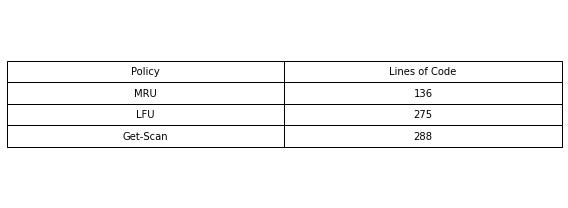

In [14]:
# Lines of code required for each policy

def c_file_is_loc(line: str):
    line = line.strip()
    if line.startswith("//") or line.startswith("/*") or line == "":
        return False
    return True

def c_file_count_loc(file_path: str):
    if not file_path.endswith(".c"):
        raise ValueError("File must be a C file")
    with open(file_path, "r") as f:
        lines = f.readlines()
    loc_count = 0
    for line in lines:
        if c_file_is_loc(line):
            loc_count += 1
    return loc_count

mru_loc_count = c_file_count_loc("page_cache_ext_mru.bpf.c")
lfu_loc_count = c_file_count_loc("page_cache_ext_sampling.bpf.c")
get_scan_loc_count = c_file_count_loc("page_cache_ext_get_scan.bpf.c")

# Put the LOC data in a table
table_data = [
    ["MRU", mru_loc_count],
    ["LFU", lfu_loc_count],
    ["Get-Scan", get_scan_loc_count],
]

# Create the table
fig = plt.figure(figsize=(8, 3))
table = plt.table(cellText=table_data,
                  colLabels=["Policy", "Lines of Code"],
                  cellLoc="center",
                  loc="center")

table.scale(1, 1.5)
plt.axis("off")
plt.tight_layout()
plt.show()

# Create a dataframe for the same table
df = pd.DataFrame(table_data, columns=["Policy", "Lines of Code"])
df.to_latex(FIGURES_DIR + "loc_table.tex", index=False,
            caption="Lines of code required for each policy presented.",
            label="tab:loc-per-policy")


## FIO Microbenchmark

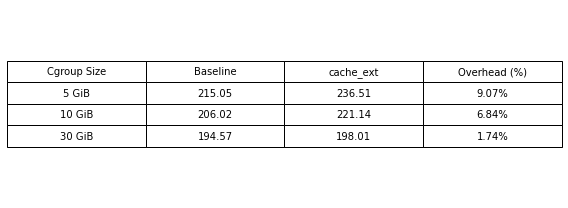

In [19]:
# Plot fio results

baseline_fio_results = bench_lib.parse_results_file("baseline_fio_results.json", bench_lib.BenchResults)
cache_ext_fio_results = bench_lib.parse_results_file("fio_results.json", bench_lib.BenchResults)
cache_ext_fio_results = filter_cache_ext_results(cache_ext_fio_results)
fio_results = baseline_fio_results + cache_ext_fio_results

cgroup_size = 30 * GiB
cgroup_sizes = [5 * GiB, 10 * GiB, 20 * GiB, 30 * GiB]

baseline_config_match = {
    "name": "fio_benchmark",
    "workload": "randread",
    "cgroup_name": "baseline_test",
}

cache_ext_config_match = {
    "name": "fio_benchmark",
    "workload": "randread",
    "cgroup_name": "cache_ext_test",
}

baseline_iops = {}
cache_ext_iops = {}
iops_diff = {}
for cgroup_size in cgroup_sizes:
    baseline_config_match["cgroup_size"] = cgroup_size
    baseline_iops[cgroup_size] = plot_lib.results_select(fio_results, baseline_config_match, iops_select_fn)
    baseline_iops[cgroup_size] = np.mean(baseline_iops[cgroup_size])
    cache_ext_iops[cgroup_size] = plot_lib.results_select(fio_results, cache_ext_config_match, iops_select_fn)
    cache_ext_iops[cgroup_size] = np.mean(cache_ext_iops[cgroup_size])
    iops_diff[cgroup_size] = (cache_ext_iops[cgroup_size] - baseline_iops[cgroup_size]) / cache_ext_iops[cgroup_size] * 100


baseline_cpu_usage = {}
cache_ext_cpu_usage = {}
cpu_usage_diff = {}
for cgroup_size in cgroup_sizes:
    baseline_config_match["cgroup_size"] = cgroup_size
    baseline_cpu = plot_lib.results_select(fio_results, baseline_config_match, lambda r: r["cpu_usage"])
    baseline_cpu_usage[cgroup_size] = np.mean(baseline_cpu) / baseline_iops[cgroup_size] * 10**6

    cache_ext_config_match["cgroup_size"] = cgroup_size
    cache_ext_cpu = plot_lib.results_select(fio_results, cache_ext_config_match, lambda r: r["cpu_usage"])
    cache_ext_cpu_usage[cgroup_size] = np.mean(cache_ext_cpu) / cache_ext_iops[cgroup_size] * 10**6

    cpu_usage_diff[cgroup_size] = (cache_ext_cpu_usage[cgroup_size] - baseline_cpu_usage[cgroup_size]) / cache_ext_cpu_usage[cgroup_size] * 100

# print(baseline_cpu_usage)

# Put the CPU overhead data in a table
table_data = []

# Add a row for CPU usage
table_data.extend([
    ["5 GiB", f"{baseline_cpu_usage[5*GiB]:.2f}", f"{cache_ext_cpu_usage[5*GiB]:.2f}", f"{cpu_usage_diff[5*GiB]:.2f}%"],
    ["10 GiB", f"{baseline_cpu_usage[10*GiB]:.2f}", f"{cache_ext_cpu_usage[10*GiB]:.2f}", f"{cpu_usage_diff[10*GiB]:.2f}%"],
    ["30 GiB", f"{baseline_cpu_usage[30*GiB]:.2f}", f"{cache_ext_cpu_usage[30*GiB]:.2f}", f"{cpu_usage_diff[30*GiB]:.2f}%"],
])

# Create the table
fig = plt.figure(figsize=(8, 3))
table = plt.table(cellText=table_data,
                  colLabels=["Cgroup Size", "Baseline", SYS_NAME, "Overhead (%)"],
                  cellLoc="center",
                  loc="center")
table.scale(1, 1.5)
plt.axis("off")
plt.tight_layout()
plt.show()

# Create a dataframe for the same table
df = pd.DataFrame(table_data, columns=["Cgroup Size", "Baseline", SYS_NAME, "Overhead (%)"])
df.to_latex(FIGURES_DIR + "cpu_overhead_table.tex", index=False,
            caption="fio microbenchmark results to measure CPU overhead of \name per IO operation.",
            label="tab:eval-cpu-overhead",)


In [17]:
google_io_trace_results = bench_lib.parse_results_file("io_trace_results.json", bench_lib.BenchResults)

config_matches = [
    {
        "name": "iotrace_benchmark",
        "iteration": 1,
    }
]

config_matches = bench_lib.add_config_option("cgroup_size", [5 * GiB, 10 * GiB], config_matches)
config_matches = bench_lib.add_config_option("cgroup_name", [bench_lib.DEFAULT_BASELINE_CGROUP, bench_lib.DEFAULT_CACHE_EXT_CGROUP], config_matches)


plot_lib.bench_plot_groupped_results(
    config_matches,
    google_io_trace_results,
    colors=["salmon", "maroon", "limegreen", "olivedrab"],
    bench_types=["trace_cluster1_16TB_20240115_data-00000-of-00100"],
    filename="leveldb_ycsb_results.pdf",
    bar_width=0.3,
)

{'name': 'iotrace_benchmark', 'iteration': 1, 'cgroup_size': 5368709120, 'cgroup_name': 'baseline_test', 'benchmark': 'trace_cluster1_16TB_20240115_data-00000-of-00100'}
[432.71]
{'name': 'iotrace_benchmark', 'iteration': 1, 'cgroup_size': 5368709120, 'cgroup_name': 'cache_ext_test', 'benchmark': 'trace_cluster1_16TB_20240115_data-00000-of-00100'}
[914.49]
{'name': 'iotrace_benchmark', 'iteration': 1, 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'benchmark': 'trace_cluster1_16TB_20240115_data-00000-of-00100'}
[52.77]
{'name': 'iotrace_benchmark', 'iteration': 1, 'cgroup_size': 10737418240, 'cgroup_name': 'cache_ext_test', 'benchmark': 'trace_cluster1_16TB_20240115_data-00000-of-00100'}
[46.1]
[[432.71], [914.49], [52.77], [46.1]]
['Baseline', 'cache_ext', 'Baseline', 'cache_ext']
[-0.45 -0.15  0.15  0.45]
[-0.45]
[-0.15]
[0.15]
[0.45]


<Figure size 432x288 with 0 Axes>